# Maximum Likelihood Estimation with UQpy

Authors: Audrey Olivier, Dimitris G. Giovanis <br>
Last modified on 05/13/2020 by Audrey Olivier

This notebook illustrates the use of the Model class to create a model for inference, and the MLEstimation class to perform maximum likelihood estimation of the parameters of that model. Recall that a maximum likelihood estimate is simply the parameter vector that maximizes the likelihood:

$$ \theta_{ML} = argmax_{\Theta} \quad p(data \vert \theta) $$

In [1]:
# Basic imports
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Inference import InferenceModel, MLEstimation

## Learning a simple probability distribution model

In the following we learn the mean and covariance of a univariate gaussian distribution from data.

First, for the sake of this example, we generate fake data from a gaussian distribution with mean 0 and standard deviation 1.

Shape of data vector: (1000, 1)


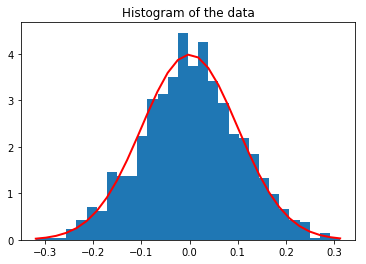

In [2]:
mu, sigma = 0, 0.1 # true mean and standard deviation
data_1 = np.random.normal(mu, sigma, 1000).reshape((-1,1))
print('Shape of data vector: {}'.format(data_1.shape))

count, bins, ignored = plt.hist(data_1, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title('Histogram of the data')
plt.show()

Create an instance of the class Model. The user must define the number of parameters to be estimated, in this case 2 (mean and standard deviation), and set those parameters to be learnt as None when instantiating the Distribution object. For maximum likelihood estimation, no prior pdf is required.

In [3]:
from UQpy.Distributions import Normal
# set parameters to be learnt as None
dist = Normal(loc=None, scale=None)
candidate_model = InferenceModel(nparams=2, dist_object=dist)

In [4]:
ml_estimator = MLEstimation(inference_model=candidate_model, data=data_1, verbose=True, iter_optim=3)
print('ML estimates of the mean={0:.3f} (true=0.) and std. dev={1:.3f} (true=0.1)'.format(
    ml_estimator.mle[0], ml_estimator.mle[1]))

UQpy: Initialization of MLEstimation object completed.
UQpy: Evaluating maximum likelihood estimate for inference model 
ML estimates of the mean=0.003 (true=0.) and std. dev=0.102 (true=0.1)


We can also fix one of the parameters and learn the remaining one

In [5]:
from UQpy.Distributions import Normal
d = Normal(loc=0., scale=None)
candidate_model = InferenceModel(nparams=1, dist_object=d)

ml_estimator = MLEstimation(inference_model=candidate_model, data=data_1, verbose=True,
                            iter_optim=1, bounds=[[0.0001, 2.]])
print('ML estimates of the std. dev={0:.3f} (true=0.1)'.format(ml_estimator.mle[0]))

#Question: use loc or floc?

UQpy: Initialization of MLEstimation object completed.
UQpy: Evaluating maximum likelihood estimate for inference model 
ML estimates of the std. dev=0.102 (true=0.1)


## Learn a more complex probability model

Here we define a bivariate probability model, with a dependence structure defined using a gumbel copula. The goal of inference is to learn the paremeters of the Gaussian marginals and the copula parameter, i.e., the model has 5 unknown parameters. 

First data is generated from a true model. A distribution with copulas does not possess a fit method, thus sampling is performed using importance sampling/resampling.

In [6]:
from UQpy.Distributions import JointInd, JointCopula, Gumbel

Shape of data: (5000, 2)


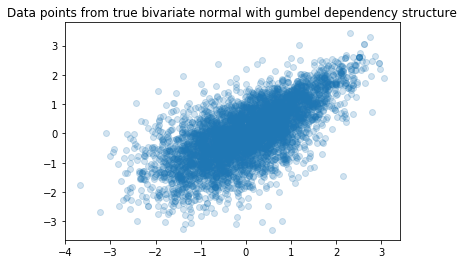

In [7]:
# dist_true exhibits dependence between the two dimensions, defined using a gumbel copula
dist_true = JointCopula(marginals=[Normal(), Normal()], copula=Gumbel(theta=2.))

# generate data using importance sampling: sample from a bivariate gaussian without copula, then weight samples
from UQpy.SampleMethods import IS
u = IS(proposal=JointInd(marginals=[Normal(), Normal()]), 
       log_pdf_target=dist_true.log_pdf, nsamples = 500000)
# Resample to obtain 5,000 data points
data_2 = u.resample(nsamples=5000)
print('Shape of data: {}'.format(data_2.shape))

fig, ax = plt.subplots()
ax.scatter(data_2[:,0], data_2[:,1], alpha=0.2)
ax.set_title('Data points from true bivariate normal with gumbel dependency structure')
plt.show()

To define a model for inference, the user must create a custom file, here bivariate_normal_gumbel.py, to compute the log_pdf of the distribution, given a bivariate data matrix and a parameter vector of length 5. Note that for any probability model that is not one of the simple univariate pdfs supported by UQpy, such a custom file will be necessary.

In [8]:
d_guess = JointCopula(marginals=[Normal(loc=None, scale=None), Normal(loc=None, scale=None)],
                      copula=Gumbel(theta=None))
print(d_guess.get_params())
candidate_model = InferenceModel(nparams=5, dist_object=d_guess)
print(candidate_model.list_params)

{'loc_0': None, 'scale_0': None, 'loc_1': None, 'scale_1': None, 'theta_c': None}
['loc_0', 'scale_0', 'loc_1', 'scale_1', 'theta_c']


When calling MLEstimation, the function minimize from the scipy.optimize package is used by default. The user can define bounds for the optimization, a seed, the algorithm to be used, and set the algorithm to perform several optimization iterations, starting at a different random seed every time.

In [9]:
ml_estimator = MLEstimation(inference_model=candidate_model, data=data_2, verbose=True,
                            bounds=[[-5, 5], [0, 10], [-5, 5], [0, 10], [1.1, 4]], method='SLSQP')

UQpy: Initialization of MLEstimation object completed.


In [10]:
ml_estimator.run(x0=[1., 1., 1., 1., 4.])

print('ML estimates of the mean={0:.3f} and std. dev={1:.3f} of 1st marginal (true: 0.0, 1.0)'.
      format(ml_estimator.mle[0], ml_estimator.mle[1]))
print('ML estimates of the mean={0:.3f} and std. dev={1:.3f} of 2nd marginal (true: 0.0, 1.0)'.
      format(ml_estimator.mle[2], ml_estimator.mle[3]))
print('ML estimates of the copula parameter={0:.3f} (true: 2.0)'.format(ml_estimator.mle[4]))

UQpy: Evaluating maximum likelihood estimate for inference model 


/Users/audreyolivier/Documents/JHU_Research/UQpy/src/UQpy/Distributions.py:1259: RuntimeWarning: divide by zero encountered in power
  * (np.log(u) * np.log(v)) ** (theta - 1) * \
/Users/audreyolivier/Documents/JHU_Research/UQpy/src/UQpy/Distributions.py:1259: RuntimeWarning: invalid value encountered in multiply
  * (np.log(u) * np.log(v)) ** (theta - 1) * \
/Users/audreyolivier/Documents/JHU_Research/UQpy/src/UQpy/Distributions.py:1260: RuntimeWarning: divide by zero encountered in power
  (1 + (theta - 1) * ((-np.log(u)) ** theta + (-np.log(v)) ** theta) ** (-1 / theta))
/Users/audreyolivier/Documents/JHU_Research/UQpy/src/UQpy/Distributions.py:1256: RuntimeWarning: divide by zero encountered in log
  c = np.exp(-((-np.log(u)) ** theta + (-np.log(v)) ** theta) ** (1 / theta))
/Users/audreyolivier/Documents/JHU_Research/UQpy/src/UQpy/Distributions.py:1259: RuntimeWarning: invalid value encountered in true_divide
  * (np.log(u) * np.log(v)) ** (theta - 1) * \
/Users/audreyolivier/Docu

UQpy: ML estimation completed.
ML estimates of the mean=0.011 and std. dev=0.990 of 1st marginal (true: 0.0, 1.0)
ML estimates of the mean=-0.005 and std. dev=0.997 of 2nd marginal (true: 0.0, 1.0)
ML estimates of the copula parameter=1.949 (true: 2.0)


Again, some known parameters can be fixed during learning.

In [11]:
d_guess = JointCopula(marginals=[Normal(loc=None, scale=None), Normal(loc=0., scale=1.)],
                      copula=Gumbel(theta=None))
candidate_model = InferenceModel(nparams=3, dist_object=d_guess)

ml_estimator = MLEstimation(inference_model=candidate_model, data=data_2, verbose=True,
                            bounds=[[-5, 5], [0, 10], [1.1, 4]], method='SLSQP')

ml_estimator.run(x0=[1., 1., 4.])

print('ML estimates of the mean={0:.3f} and std. dev={1:.3f} of 1st marginal (true: 0.0, 1.0)'.
      format(ml_estimator.mle[0], ml_estimator.mle[1]))
print('ML estimates of the copula parameter={0:.3f} (true: 2.0)'.format(ml_estimator.mle[2]))

UQpy: Initialization of MLEstimation object completed.
UQpy: Evaluating maximum likelihood estimate for inference model 
UQpy: ML estimation completed.
ML estimates of the mean=0.015 and std. dev=0.993 of 1st marginal (true: 0.0, 1.0)
ML estimates of the copula parameter=1.956 (true: 2.0)


## Regression model

Here a model is defined that is of the form 

$$y=f(\theta) + \epsilon$$

where f consists in running RunModel. In particular, here $f(\theta)=\theta_{0} x + \theta_{1} x^{2}$ is a regression model.

First we generate synthetic data, and add some noise to it.

In [12]:
# Generate data
from UQpy.Distributions import Normal
from UQpy.RunModel import RunModel

param_true = np.array([1.0, 2.0]).reshape((1, -1))
print('Shape of true parameter vector: {}'.format(param_true.shape))

#h_func = RunModel(model_script='pfn_models.py', model_object_name='model_quadratic_vectorized', 
#                  var_names=['theta_0', 'theta_1'])
h_func = RunModel(model_script='pfn_models.py', model_object_name='model_quadratic', vec=False, 
                  var_names=['theta_0', 'theta_1'])
h_func.run(samples=param_true)

# Add noise
error_covariance = 1.
data_clean = np.array(h_func.qoi_list[0])
noise = Normal(loc=0., scale=np.sqrt(error_covariance)).rvs(nsamples=50).reshape((50, ))
data_3 = data_clean + noise
print('Shape of data: {}'.format(data_3.shape))

Shape of true parameter vector: (1, 2)
Shape of data: (50,)


Then we create an instance of the Model class, using model_type='python', and we perform maximum likelihood estimation of the two parameters.

In [13]:
candidate_model = InferenceModel(nparams=2, run_model_object=h_func, error_covariance=error_covariance)

In [14]:
ml_estimator = MLEstimation(inference_model=candidate_model, data=data_3, method='nelder-mead', iter_optim=1)
print('fitted parameters: theta_0={0:.3f} (true=1.), and theta_1={1:.3f} (true=2.)'.format(
    ml_estimator.mle[0], ml_estimator.mle[1]))

fitted parameters: theta_0=1.065 (true=1.), and theta_1=1.989 (true=2.)
